<a href="https://colab.research.google.com/github/haryobimo96/dicoding-ML/blob/main/ImageClassificationDicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dicoding Submission for "Learning Machine Learning Development"
# Image Classification Model Deployment

By: Haryo Bimo Cokrokusumo

Depok, Jawa Barat

**Step 1**: Import dataset from Kaggle

The dataset used is retrieved from https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda

In [ ]:
! pip install -q kaggle

Upload Kaggle's API Token provided to Google Colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 98% 369M/376M [00:03<00:00, 101MB/s] 
100% 376M/376M [00:03<00:00, 122MB/s]


In [ ]:
! unzip animal-image-datasetdog-cat-and-panda.zip

Count files in each class

In [ ]:
import os

def File_Number(dir):
    list_ = os.listdir(dir)
    number_files = len(list_)
    print(number_files)

File_Number('/content/animals/animals/cats')
File_Number('/content/animals/animals/dogs')
File_Number('/content/animals/animals/panda')

1000
1000
1000


Display some examples of the images used for this project.

Note: notice the difference in image resolution used (as seen in the pyplot axes)

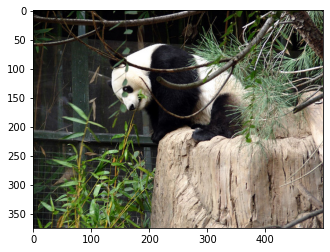

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
panda_im = Image.open('/content/animals/animals/panda/panda_00992.jpg')
dog_im = Image.open('/content/animals/animals/dogs/dogs_00631.jpg')
plt.imshow(panda_im)

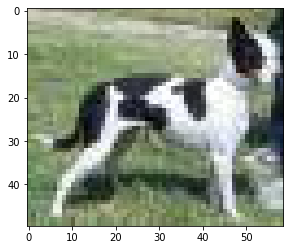

In [ ]:
plt.imshow(dog_im)

**Step 2**: Train-test split and data augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 224
img_width = 224
train_data_dir = '/content/animals/animals'
batch_size = 128

datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range = 90,
                             horizontal_flip = True,
                             vertical_flip = True,
                             shear_range = 0.2,
                             zoom_range = 0.1,
                             validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training')

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


**Step 3**: Build the model for this project

Note: VGG16 pretrained model is used for the first part of the model, pretrained on ImageNet dataset and has its weight disabled for training (thus the only weights update happen on the custom-made layers)

In [ ]:
from tensorflow.keras.applications import VGG16

input_tensor = tf.keras.layers.Input(shape=(224,224,3))
VGG16_MODEL = VGG16(include_top=False,
                    weights='imagenet',
                    input_tensor=input_tensor)
VGG16_MODEL.trainable=False

model = tf.keras.Sequential(layers=VGG16_MODEL.layers)
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (5,5),
                                 strides = (1,1), name='en_conv1',
                                 activation='relu', data_format='channels_last'))
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), 
                                    strides = (1,1), 
                                    name='maxpool_1', 
                                    data_format = 'channels_last'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 32, 
                                activation ='relu', 
                                input_shape=(64,)))
model.add(tf.keras.layers.Dense(units = 16, 
                                activation ='relu'))
model.add(tf.keras.layers.Dense(units = 3, 
                                activation ='softmax'))

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [ ]:
Adam = tf.keras.optimizers.Adam()
model.compile(optimizer = Adam, loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

**Step 4**: Train the model

In [ ]:
import math
import time

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.9
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

class History(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.val_losses = []
       self.accuracies = []
       self.val_accuracies = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.val_losses.append(logs.get('val_loss'))
       self.accuracies.append(logs.get('accuracy'))
       self.val_accuracies.append(logs.get('val_accuracy'))
       self.lr.append(step_decay(len(self.losses)))

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=2,
    mode='min', restore_best_weights=True
    )

history = History()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [history, lrate, early_stop]

hist = model.fit(train_generator,
                validation_data = valid_generator, 
                epochs = 50,
                callbacks = callbacks_list)

Epoch 1/50
19/19 [==============================] - 38s 2s/step - loss: 1.0761 - accuracy: 0.4050 - val_loss: 1.0008 - val_accuracy: 0.5433
Epoch 2/50
19/19 [==============================] - 36s 2s/step - loss: 0.9526 - accuracy: 0.5746 - val_loss: 0.8789 - val_accuracy: 0.6383
Epoch 3/50
19/19 [==============================] - 37s 2s/step - loss: 0.8340 - accuracy: 0.6388 - val_loss: 0.8019 - val_accuracy: 0.6733
Epoch 4/50
19/19 [==============================] - 35s 2s/step - loss: 0.7498 - accuracy: 0.6858 - val_loss: 0.7202 - val_accuracy: 0.7200
Epoch 5/50
19/19 [==============================] - 36s 2s/step - loss: 0.6939 - accuracy: 0.7179 - val_loss: 0.6288 - val_accuracy: 0.7633
Epoch 6/50
19/19 [==============================] - 35s 2s/step - loss: 0.6134 - accuracy: 0.7608 - val_loss: 0.5594 - val_accuracy: 0.7917
Epoch 7/50
19/19 [==============================] - 36s 2s/step - loss: 0.5563 - accuracy: 0.8042 - val_loss: 0.5072 - val_accuracy: 0.7900
Epoch 8/50
19/19 [==

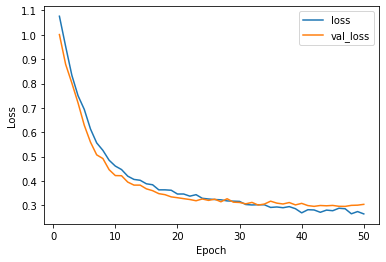

In [ ]:
import numpy as np

X = np.arange(len(history.losses)) + 1
loss = plt.plot(X, history.losses)
val_loss = plt.plot(X, history.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

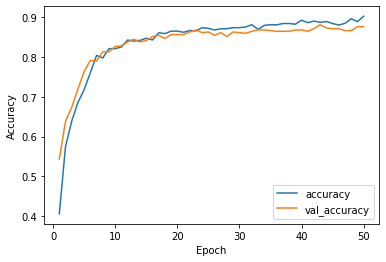

In [ ]:
y = np.arange(len(history.accuracies)) + 1
loss = plt.plot(y, history.accuracies)
val_loss = plt.plot(y, history.val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

**Step 5**: Convert model to deployment-ready TFLite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5kp9u2zx/assets
